Below is a demo of jhu_primitives. The data set we use is DS01876 = datasetID (as defined by d3m). In particular, for visualization purposes, we use the induced subgraph of the first 50 vertices, as defined by their node ID.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import d3m
from d3m.container import pandas as pd
from d3m.container import dataset as ds
from d3m.metadata import hyperparams

import jhu_primitives

import os
from urllib import parse as url_parse
import numpy as np
import networkx as nx

from rpy2.robjects import r
import rpy2.robjects.numpy2ri
import rpy2.robjects as ro

In [3]:
def data_file_path_conversion(abs_file_path, uri= "", datasetDoc = False):
    local_drive, file_path = abs_file_path.split(':')[0], abs_file_path.split(':')[1]
    path_sep = file_path[0]
    file_path = file_path[1:]  # Remove initial separator
    if len(file_path) == 0:
        print("Invalid file path: len(file_path) == 0")
        return
    
    valid_type = False
    while not valid_type:
        type_ = input("Enter \n 0: exit \n 1: seed_datasets_current \n 2: training_datasets \n"
                          + " 3: if already in the data folder \n")
        if type_ == '0':
            return
        elif type_ == '1':
            data_dir = "datasets/seed_datasets_current"
            valid_type = True
        elif type_ == '2':
            data_dir = "datasets/training_datasets"
            valid_type = True
        elif type_ == '3':
            data_dir = ""
            valid_type = True
        else:
            print("Please enter 0, 1 or 2")
            
    valid_folder = False
    while not valid_folder:
        folder = input("Enter \n 0: exit \n Name of the data folder (case sensitive; must be in " + data_dir + ") \n")
        if folder == "0":
            return
        if type_ == '3':
            if os.path.isdir(folder):
                data_dir += folder
                valid_folder= True
        else:
            if os.path.isdir(data_dir  + "/" + folder):
                data_dir += "/" + folder
                valid_folder = True
        
    s = ""
    if path_sep == "/":
        splits = file_path.split("/")
        #data_folder = splits[-1]
        
    elif path_sep == "\\":
        splits = file_path.split("\\")
        #data_folder = splits[-1]
        for i in splits:
            if i != "":
                s += "/" + i
    else:
        print("Unsupported path separator!")
        return

    if datasetDoc:
        s = s + "/" + data_dir + "/" + folder + "_dataset/datasetDoc.json"

    if uri == "file":
        return "file://localhost" + s
    else:
        return local_drive + ":" + s

In [55]:
abs_file_path = os.path.abspath(os.getcwd())
dataset_uri = data_file_path_conversion(abs_file_path, uri = "file", datasetDoc = True)

Enter 
 0: exit 
 1: seed_datasets_current 
 2: training_datasets 
 3: if already in the data folder 
1
Enter 
 0: exit 
 Name of the data folder (case sensitive; must be in datasets/seed_datasets_current) 
DS01876


In [56]:
data = ds.D3MDatasetLoader().load(dataset_uri = dataset_uri)

In [57]:
G = data['0'] # Load the first data object
G = G.subgraph(np.arange(50)).copy() # Induced subgraph on the first 50 vertices (for illustration purposes)

A = nx.to_numpy_array(G)

n = A.shape[0] # Find the number of vertices/nodes

D = np.linalg.pinv(np.diag(A.sum(axis=1))**(1/2))

L = D @ A @ D

n, A.shape, D.shape, L.shape

(50, (50, 50), (50, 50), (50, 50))

<function matplotlib.pyplot.colorbar>

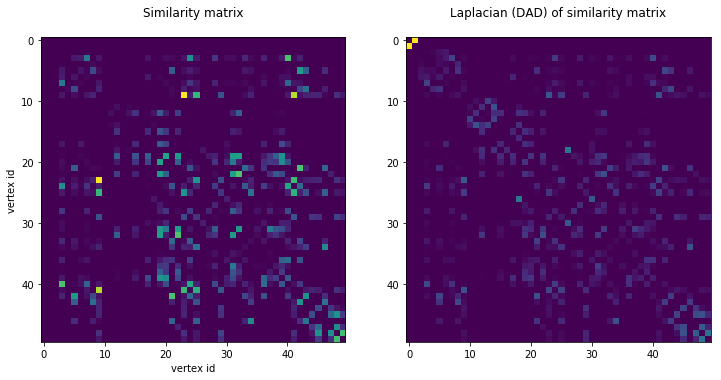

In [58]:
fig, (ax1, ax2) = subplots(1, 2, figsize = (12,8))
ax1.matshow(A)
ax1.set_ylabel('vertex id')
ax1.set_xlabel('vertex id')
ax1.set_title('Similarity matrix')
ax1.xaxis.tick_bottom()
plt.colorbar

ax2.matshow(L)
ax2.set_title('Laplacian (DAD) of similarity matrix')
ax2.xaxis.tick_bottom()
plt.colorbar

In [8]:
A = ro.Matrix(A) 
ro.r.assign("A", A)

L = ro.Matrix(L) 
ro.r.assign("L", L)

0.000000,1.000000,0.000000,0.000000,...,0.000000,0.099684,0.376517,0.000000


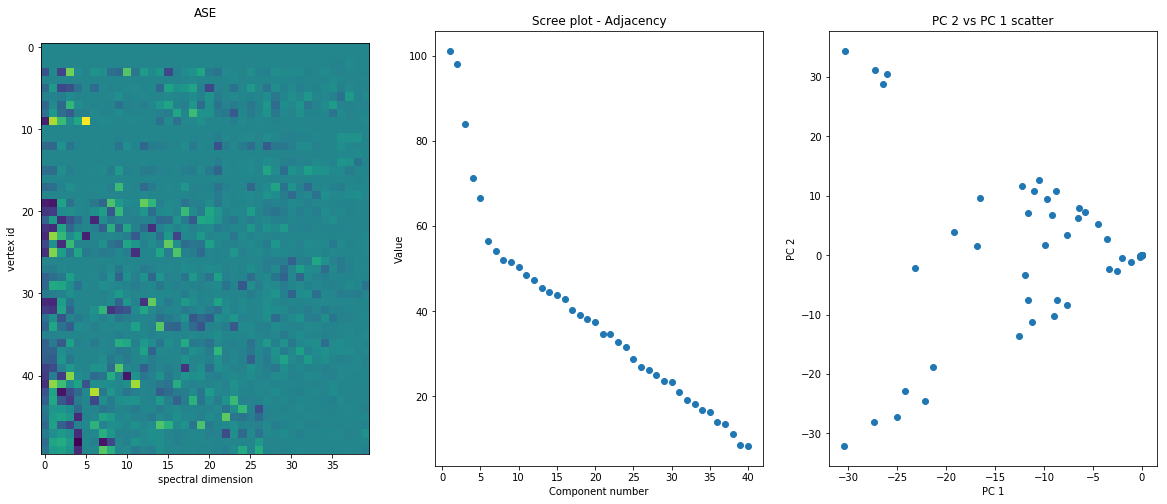

In [67]:
# ASE
d_max = 40

hp = jhu_primitives.ase.ase.Hyperparams
hp = hp({'max_dimension' : d_max})  # ASE hyperparameter(s) are: 
                                    # 'max_dimension' = maximum embedding dimension (default = 2)

ASE = jhu_primitives.AdjacencySpectralEmbedding(hyperparams = hp)
SVD = ASE.produce(inputs=A)
V = SVD.value[0]
U = SVD.value[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 8))
ax1.matshow(V)
ax1.set_xlabel('spectral dimension')
ax1.set_ylabel('vertex id')
ax1.set_title('ASE')
ax1.xaxis.tick_bottom()

#fig, ax2 = plt.subplots(1, 1, figsize = (8, 6))
ax2.scatter(arange(1,len(U) + 1), U**(1/2))
ax2.set_xlabel('Component number')
ax2.set_ylabel('Value')
ax2.set_title('Scree plot - Adjacency')
ax1.xaxis.tick_bottom()

#fig, ax3 = plt.subplots(1, 1, figsize = (8, 6))
ax3.scatter(V[:,0], V[:,1])
ax3.set_xlabel('PC 1')
ax3.set_ylabel('PC 2')
ax3.set_title('PC 2 vs PC 1 scatter')

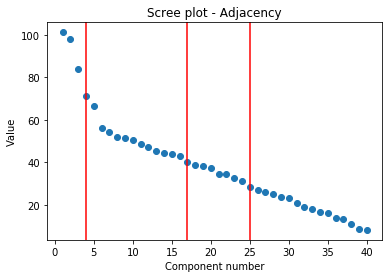

In [68]:
# Dimension selection - Adjacency

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

hp = jhu_primitives.dimselect.dimselect.Hyperparams # dimselect hyperparameters are: 
                                                    # 'n_elbows': the number of elbows to return
hp = hp({'n_elbows': 3})

dimselector = jhu_primitives.DimensionSelection(hyperparams = hp)
d_hat = dimselector.produce(inputs = U**1/2).value # First three elbows for Laplacian

ax.scatter(arange(1,len(U) + 1), U**(1/2))
for elbow in d_hat:
    ax.axvline(elbow, c = 'r')
ax.set_xlabel('Component number')
ax.set_ylabel('Value')
ax.set_title('Scree plot - Adjacency')

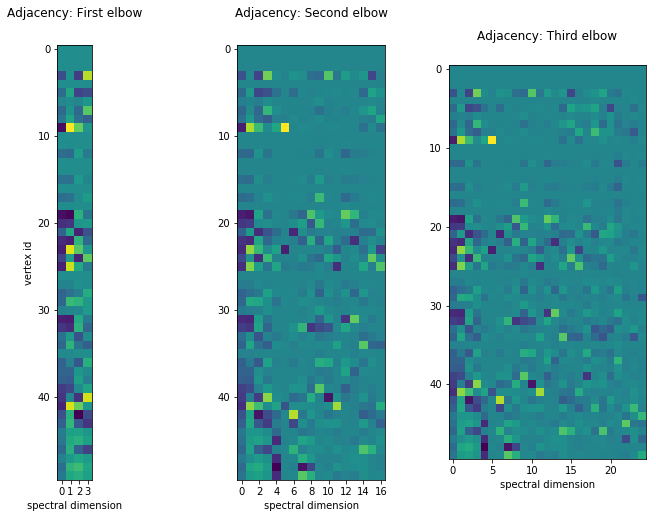

In [69]:
# ASE - first elbow

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize = (12, 8))
ax1.matshow(V[:,:d_hat[0]])
ax1.set_xlabel('spectral dimension')
ax1.set_ylabel('vertex id')
ax1.set_title('Adjacency: First elbow')
plt.colorbar
ax1.xaxis.tick_bottom()

# ASE - second elbow

ax2.matshow(V[:,:d_hat[1]])
ax2.set_xlabel('spectral dimension')
#ax2.set_ylabel('vertex id')
ax2.set_title('Adjacency: Second elbow')
plt.colorbar
ax2.xaxis.tick_bottom()

# ASE - third elbow

ax3.matshow(V[:,:d_hat[2]])
ax3.set_xlabel('spectral dimension')
#ax3.set_ylabel('vertex id')
ax3.set_title('Adjacency: Third elbow')
plt.colorbar
ax3.xaxis.tick_bottom()

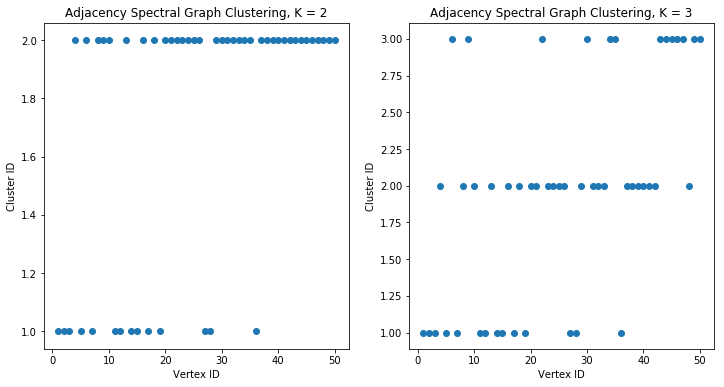

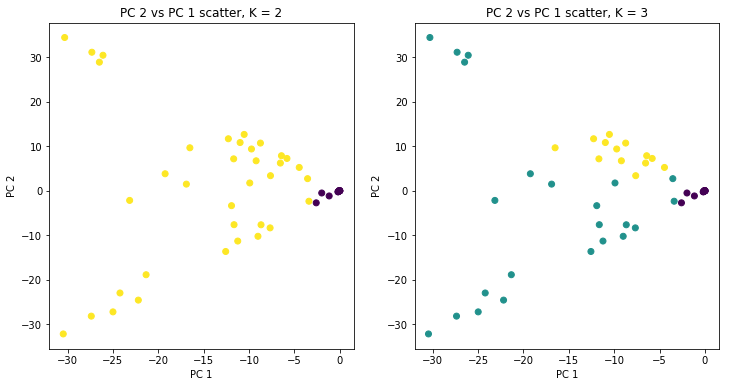

In [70]:
# GaussianClustering - ASE - First Elbow

hp = jhu_primitives.gclust.gclust.Hyperparams({'max_clusters': 2}) # gclust hyperparameter(s) are: 
                                                                   # 'max_clusters' = number of clusters (default = 2)
gc = jhu_primitives.GaussianClustering(hyperparams = hp)
ASEclustering_k2 = gc.produce(inputs = V[:,:int(d_hat[0])]).value

hp = jhu_primitives.gclust.gclust.Hyperparams({'max_clusters': 3})
gc = jhu_primitives.GaussianClustering(hyperparams = hp)
ASEclustering_k3 = gc.produce(inputs = V[:,:int(d_hat[0])]).value

fig, (ax1, ax2) = subplots(1, 2, figsize = (12, 6))
ax1.scatter(arange(1, len(ASEclustering_k2) + 1), ASEclustering_k2)
ax1.set_ylabel('Cluster ID')
ax1.set_xlabel('Vertex ID')
ax1.set_title('Adjacency Spectral Graph Clustering, K = 2')

ax2.scatter(arange(1, len(ASEclustering_k3) + 1), ASEclustering_k3)
ax2.set_ylabel('Cluster ID')
ax2.set_xlabel('Vertex ID')
ax2.set_title('Adjacency Spectral Graph Clustering, K = 3')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.scatter(V[:,0], V[:, 1], c = ASEclustering_k2)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_title('PC 2 vs PC 1 scatter, K = 2')

ax2.scatter(V[:,0], V[:, 1], c = ASEclustering_k3)
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('PC 2 vs PC 1 scatter, K = 3')

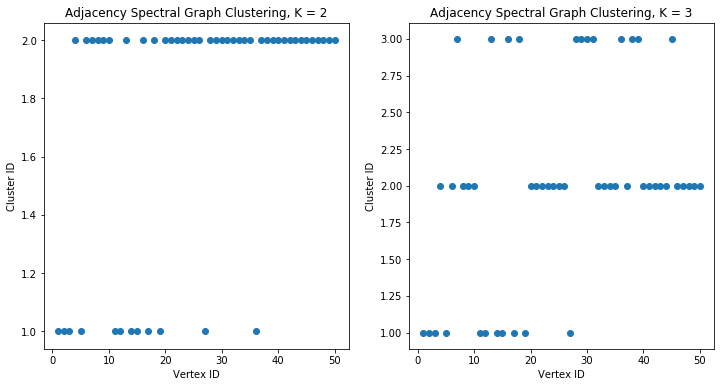

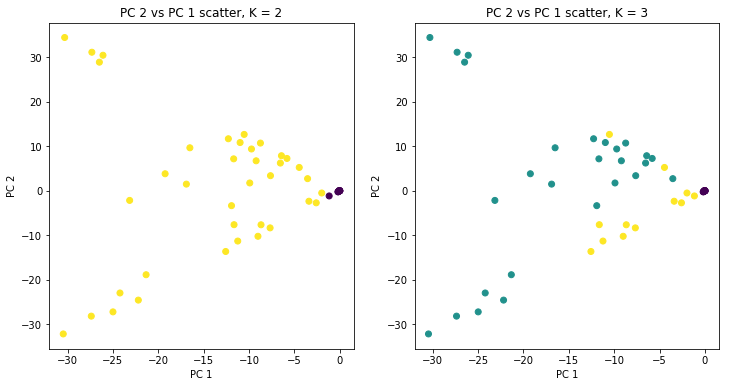

In [71]:
# GaussianClustering - ASE - Second Elbow

hp = jhu_primitives.gclust.gclust.Hyperparams({'max_clusters': 2}) # gclust hyperparameter(s) are: 
                                                                   # 'max_clusters' = number of clusters (default = 2)
gc = jhu_primitives.GaussianClustering(hyperparams = hp)
ASEclustering_k2 = gc.produce(inputs = V[:,:int(d_hat[1])]).value

hp = jhu_primitives.gclust.gclust.Hyperparams({'max_clusters': 3})
gc = jhu_primitives.GaussianClustering(hyperparams = hp)
ASEclustering_k3 = gc.produce(inputs = V[:,:int(d_hat[1])]).value

fig, (ax1, ax2) = subplots(1, 2, figsize = (12, 6))
ax1.scatter(arange(1, len(ASEclustering_k2) + 1), ASEclustering_k2)
ax1.set_ylabel('Cluster ID')
ax1.set_xlabel('Vertex ID')
ax1.set_title('Adjacency Spectral Graph Clustering, K = 2')

ax2.scatter(arange(1, len(ASEclustering_k3) + 1), ASEclustering_k3)
ax2.set_ylabel('Cluster ID')
ax2.set_xlabel('Vertex ID')
ax2.set_title('Adjacency Spectral Graph Clustering, K = 3')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.scatter(V[:,0], V[:, 1], c = ASEclustering_k2)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_title('PC 2 vs PC 1 scatter, K = 2')

ax2.scatter(V[:,0], V[:, 1], c = ASEclustering_k3)
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('PC 2 vs PC 1 scatter, K = 3')

In [72]:
gclustering == gclustering2 # including more/less dimensions can yield different clustering results

ndarray([ True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True])

In [73]:
#LSE

d_max = 40

hp = jhu_primitives.lse.lse.Hyperparams
hp = hp({'max_dimension' : d_max})  # LSE hyperparameter(s) are:
                                    # 'max_dimension' = maximum embedding dimension (default = 2)

LSE = jhu_primitives.LaplacianSpectralEmbedding(hyperparams = hp)
SVD = LSE.produce(inputs=A) # Uses the 'DAD' Laplacian
V_L = SVD.value[0]
U_L = SVD.value[1]

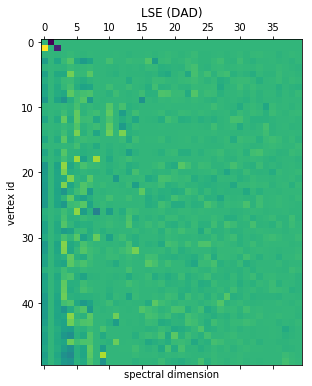

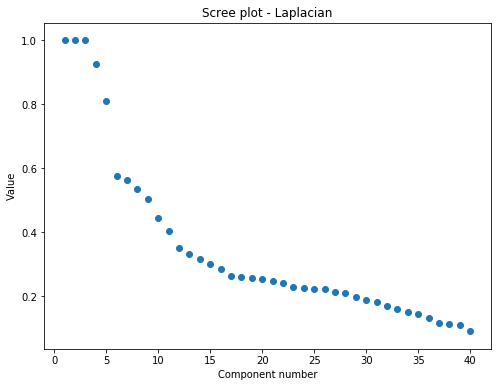

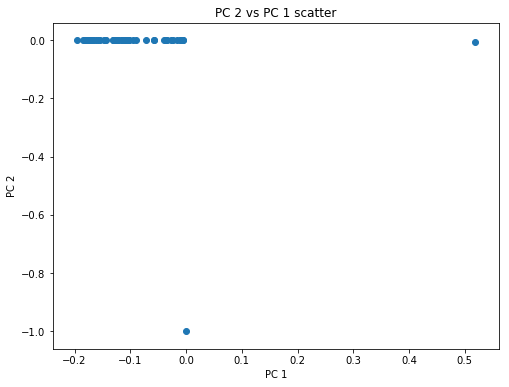

In [74]:
fig, ax1 = plt.subplots(1, 1, figsize = (8, 6))
ax1.matshow(V_L)
ax1.set_xlabel('spectral dimension')
ax1.set_ylabel('vertex id')
ax1.set_title('LSE (DAD)')

fig, ax2 = plt.subplots(1, 1, figsize = (8, 6))
ax2.scatter(arange(1,len(U_L) + 1), U_L**(1/2))
ax2.set_xlabel('Component number')
ax2.set_ylabel('Value')
ax2.set_title('Scree plot - Laplacian')

fig, ax3 = plt.subplots(1, 1, figsize = (8, 6))
ax3.scatter(V_L[:,0], V_L[:, 1])
ax3.set_xlabel('PC 1')
ax3.set_ylabel('PC 2')
ax3.set_title('PC 2 vs PC 1 scatter')

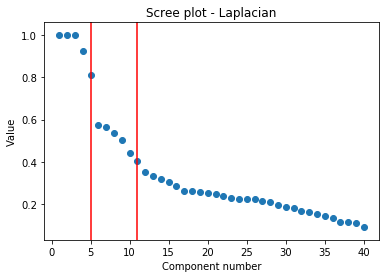

In [75]:
# DimensionSelection - Laplacian

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#V, U, _ = np.linalg.svd(A2)

hp = jhu_primitives.dimselect.dimselect.Hyperparams # dimselect hyperparameters are: 
                                                    # 'n_elbows': the number of elbows to return (default = 3)
hp = hp({'n_elbows': 2})

dimselector = jhu_primitives.DimensionSelection(hyperparams = hp)
d_hat_L = dimselector.produce(inputs = U_L).value

ax.scatter(arange(1,len(U_L) + 1), U_L**(1/2))
for elbow in d_hat_L:
    ax.axvline(elbow, c = 'r')
ax.set_xlabel('Component number')
ax.set_ylabel('Value')
ax.set_title('Scree plot - Laplacian')

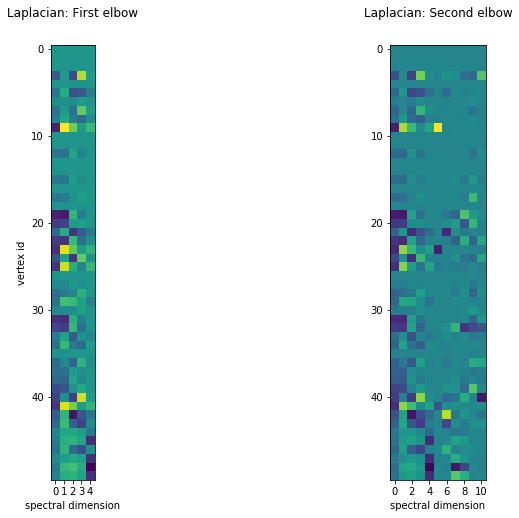

In [76]:
# LSE - first elbow

fig, (ax1, ax2) = subplots(1, 2, figsize = (12, 8))
ax1.matshow(V[:,:d_hat_L[0]])
ax1.set_xlabel('spectral dimension')
ax1.set_ylabel('vertex id')
ax1.set_title('Laplacian: First elbow')
plt.colorbar
ax1.xaxis.tick_bottom()

# LSE - second elbow

ax2.matshow(V[:,:d_hat_L[1]])
ax2.set_xlabel('spectral dimension')
ax2.set_title('Laplacian: Second elbow')
plt.colorbar
ax2.xaxis.tick_bottom()

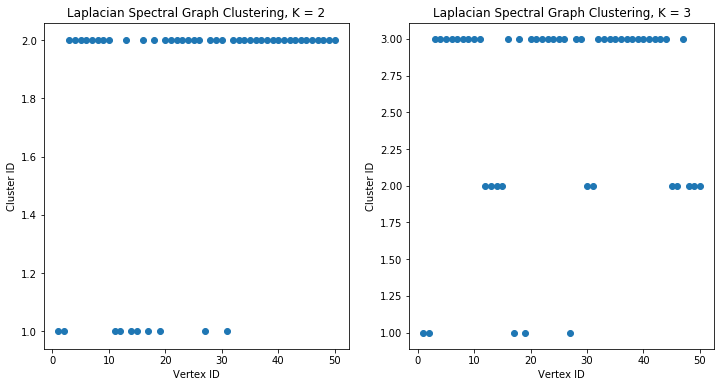

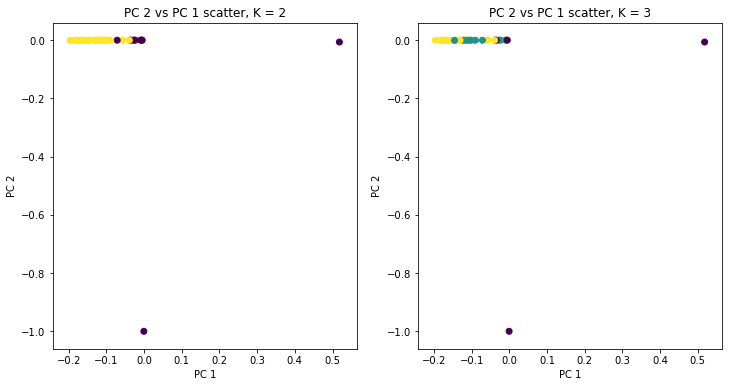

In [77]:
# GaussianClustering - LSE - Second Elbow

hp = jhu_primitives.gclust.gclust.Hyperparams({'max_clusters': 2}) # gclust hyperparameter(s) are: 'dim' = number of clusters (default = 2)
gc = jhu_primitives.GaussianClustering(hyperparams = hp)
LSEclustering_k2 = gc.produce(inputs = V_L[:,:int(d_hat_L[1])]).value

hp = jhu_primitives.gclust.gclust.Hyperparams({'max_clusters': 3})
gc = jhu_primitives.GaussianClustering(hyperparams = hp)
LSEclustering_k3 = gc.produce(inputs = V_L[:,:int(d_hat_L[1])]).value

fig, (ax1, ax2) = subplots(1, 2, figsize = (12, 6))
ax1.scatter(arange(1, len(LSEclustering_k2) + 1), LSEclustering_k2)
ax1.set_ylabel('Cluster ID')
ax1.set_xlabel('Vertex ID')
ax1.set_title('Laplacian Spectral Graph Clustering, K = 2')

ax2.scatter(arange(1, len(LSEclustering_k3) + 1), LSEclustering_k3)
ax2.set_ylabel('Cluster ID')
ax2.set_xlabel('Vertex ID')
ax2.set_title('Laplacian Spectral Graph Clustering, K = 3')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.scatter(V_L[:,0], V_L[:, 1], c = LSEclustering_k2)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_title('PC 2 vs PC 1 scatter, K = 2')

ax2.scatter(V_L[:,0], V_L[:, 1], c = LSEclustering_k3)
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('PC 2 vs PC 1 scatter, K = 3')

<function matplotlib.pyplot.colorbar>

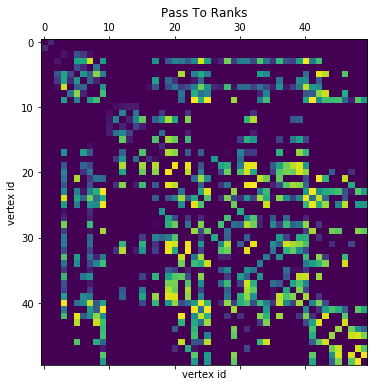

In [78]:
# PassToRanks - For weighted graphs

hp = jhu_primitives.ptr.ptr.Hyperparams # PTR hyperparameters are: 
                                        # None
hp = hp.defaults
ptr = jhu_primitives.PassToRanks(hyperparams = hp)
passtoranks = ptr.produce(inputs = A).value

fig, ax = subplots(1, 1, figsize=(8, 6))
ax.matshow(passtoranks)
ax.set_xlabel('vertex id')
ax.set_ylabel('vertex id')
ax.set_title('Pass To Ranks')
plt.colorbar

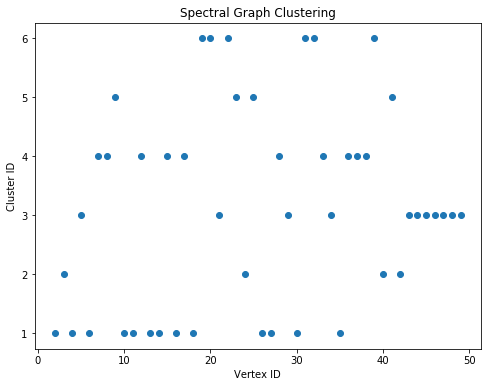

48


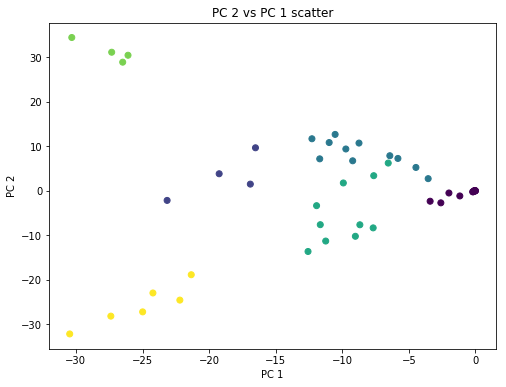

In [79]:
# Spectral Graph Clustering - 'Super' primitive

hp = jhu_primitives.sgc.sgc.Hyperparams # sgc hyperparameters are: 
                                        # None
hp = hp.defaults() 
sgc = jhu_primitives.SpectralGraphClustering(hyperparams = hp)
clusters = sgc.produce(inputs = A).value

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(arange(2, 50), clusters)
ax.set_ylabel('Cluster ID')
ax.set_xlabel('Vertex ID')
ax.set_title('Spectral Graph Clustering')
fig.set_size_inches(8, 6)
plt.show()


print(len(clusters))

fig, ax3 = plt.subplots(1, 1, figsize = (8, 6))
ax3.scatter(V[2:, 0], V[2:, 1], c = clusters)
ax3.set_xlabel('PC 1')
ax3.set_ylabel('PC 2')
ax3.set_title('PC 2 vs PC 1 scatter')

ndarray([-1.01812157])

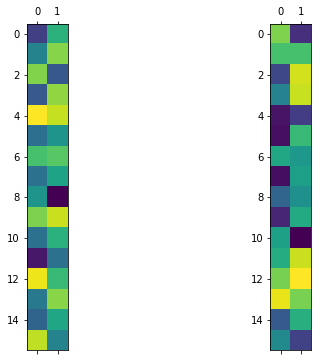

In [80]:
# NonParametricCLustering

hp = jhu_primitives.nonpar.nonpar.Hyperparams  # NPC hyperparameter(s) are: 
                                               # 'sigma' = scale of Gaussian (default = 0.5)
npc = jhu_primitives.NonParametricClustering(hyperparams = hp.defaults())

np.random.seed(1234)
xhat1 = np.random.random((16, 2))
xhat2 = np.random.random((16, 2))

fig, (ax1, ax2) = subplots(1,2, figsize = (8,6))
ax1.matshow(xhat1)
ax2.matshow(xhat2)

inputs = [xhat1, xhat2]

npc_clustering = npc.produce(inputs = inputs).value
npc_clustering

In [2]:
graph1 = "C://Users/joshu/Documents/Research/d3m_summer/DS01876/DS01876_dataset/graphs/G1.edgelist"
graph2 = "C://Users/joshu/Documents/Research/d3m_summer/DS01876/DS01876_dataset/graphs/G2.edgelist"
g1 = nx.read_edgelist(graph1,nodetype=int, data=(('weight',float),))
g2 = nx.read_edgelist(graph2,nodetype=int, data=(('weight',float),))
g1 = g1.subgraph(np.arange(50)).copy()
g2 = g2.subgraph(np.arange(50)).copy()
g1 = nx.to_numpy_array(g1)
nr,nc = g1.shape
g1 = ro.r.matrix(g1, nrow=nr, ncol=nc)
ro.r.assign("g1", g1)
g2 = nx.to_numpy_array(g2)
nr,nc = g2.shape
g2 = ro.r.matrix(g2, nrow=nr, ncol=nc)
ro.r.assign("g2", g2)
data = np.array([g1,g2])
hp = jhu_primitives.sgm.sgm.Hyperparams
SGM = jhu_primitives.SeededGraphMatching(hyperparams=hp.defaults())
sgm_result = SGM.produce(inputs=data) #returns a permutation matrix
sgm_result.value


ndarray([[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
# VNSGM -- in progress
#hp = jhu_primitives.vnsgm.vnsgm.Hyperparams
#VNSGM = jhu_primitives.VertexNominationSeededGraphMatching(hyperparams=hp.defaults())
#seeds = np.matrix([[2],[ 3]])
#nr,nc = seeds.shape
#seeds = ro.r.matrix(seeds,nrow=nr,ncol=nc)
#ro.r.assign("seeds",seeds)
#data = np.array([g1,g2,[1],seeds]) #1 is the vertex of interest, no seeds

#VNSGM_result = VNSGM.produce(inputs = data)
# TODO


        source("C:/Users/joshu/AppData/Local/conda/conda/envs/d3m_env/lib/site-packages/jhu_primitives/vnsgm/vnsgm.interface.R")
        fn <- function(g1, g2, voi, seed = matrix(nrow = 0,ncol = 2)) {
            vnsgm.interface(g1, g2, voi, seed)
        }
        


RRuntimeError: Error in A[vec, vec] : invalid subscript type 'list'
